In [1]:
from PPM_lib import *
from teo_lib import Peb_ook, Peb_H, Peb_S

## Espectro de potencia para señales PPM

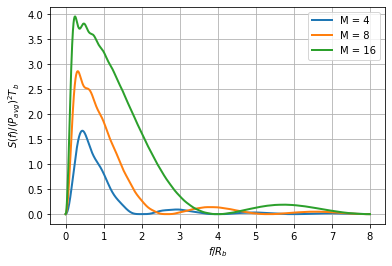

In [2]:
def S_ppm(M,Rb): # con pulsos cuadrados que ocupan todo el tiempo de slot
    k = int(np.log2(M))
    Tsymbol = k/Rb
    Tslot = Tsymbol/M
    f = np.linspace(0,8*Rb,2000)
    return f, 1/Tsymbol * ( 1-1/M + 2/M * np.array([np.sum([(i/M-1)*np.cos(2*pi*fi*i*Tsymbol/M) for i in range(1,M)]) for fi in f]) ) * (Tslot*np.sinc(Tslot*f))**2


for M in [4,8,16]: 
    Rb = 1e9
    k = np.log2(M)
    Tslot = k/M/Rb 
    norm = 1/Rb*(1/M)**2  # óptical power multiplied by the duration of bit
    f, pxx = S_ppm(M,Rb)
    plot(f/Rb, pxx/norm, label='M = %d'%M, lw=2)
    
grid()
xlabel(r'$f/R_b$')
ylabel(r'$S(f)/(P_{avg})^2T_b$')
legend()
# savefig('Cp1-ppm-espectro.png',dpi=300)
show()

## BER vs. $\hat{P_{rx}}$ para OOK, M-PPM con Hard y Soft Decision. Tasa de transmisión de 1 Gbps

### Curvas teóricas

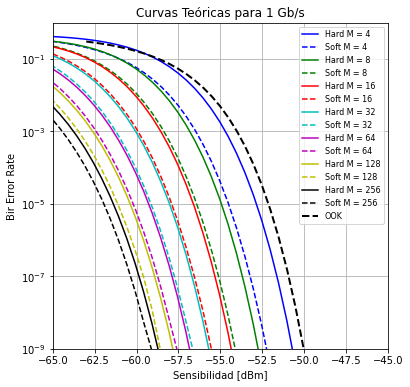

In [2]:
R = 1
nf = idb(3)
fo = c/1550e-9
g = idb(40)
Rb = 1e9
Dv = 25e9
Df = 0.5*Rb
T = 300

p1 = idbm(np.arange(-60,-25,0.5))

BER_ook = np.vectorize(Peb_ook)(R,nf,g,fo,p1,Dv,Df,T)

figure(figsize=(6,6))

colors = ['b','g','r','c','m','y','k']
k = [2,3,4,5,6,7,8]

for k,clr in zip(k, colors):
    M=2**k
    Df = 0.5*Rb*M/k
    
    BER_H = np.vectorize(Peb_H)(M,R,nf,g,fo,p1,Dv,Df,T)
    BER_S = np.vectorize(Peb_S)(M,R,nf,g,fo,p1,Dv,Df,T)

    semilogy(dbm(p1/M),BER_H,'-',c=clr,label='Hard M = %d'%M)
    semilogy(dbm(p1/M),BER_S,'--',c=clr,label='Soft M = %d'%M)

semilogy(dbm(p1/2),BER_ook,'--k',lw=2,label='OOK')

title('Curvas Teóricas para 1 Gb/s')
xlabel('Sensibilidad [dBm]')
ylabel('Bir Error Rate')
ylim(1e-9,1)
xlim(-65,-45)
grid(which='both')
legend(fontsize = 8)
show()

## BER vs. $\Delta f_{elec}$ para {4,8,16}-PPM con Hard y Soft Decision. Tasa de transmisión de 1 Gbps y Potencia recibida -57 dBm

In [ ]:
k = 2
M = 2**k

# Para lograr la misma potencia media recibida (-50 dbm)
P_laser = 7 # dbm, para M=4
# P_laser = 10 # dbm, para M=8
# P_laser = 13 # dbm, para M=16

Rb = 1e9
Dv = 25e9
Df = np.logspace(np.log10(0.5*Rb), np.log10(Dv/2), 20)

def PPM_link(Df):
    p = Parametros(P_laser = P_laser,
                    bit_rate = 1e9, 
                    nbits = 10**5, 
                    sps = int(50*k/M)+12,  # debe ser tal que la frecuencia de muestreo sea mayor al doble del ancho de banda del filtro óptico.
                    BW_opt = 25e9, 
                    BW_elec = Df,  # el ancho de banda del detector se fija a 3/4 del Slot_rate
                    G_rx = 40, 
                    NF_rx = 5, 
                    G_tx = 30, 
                    landa = 1550e-9, 
                    Responsivity = 1.0, 
                    orden_elec = 4, 
                    orden_opt = 4,
                    CHANNEL_LOSS = 81,
                    M = M)

    Tx = Transmisor(p)
    Ch = Canal(p, Tx.OUT)
    Rx = Receptor(p, Ch.OUT, Tx.ook_s)

    return Rx.BER_teo_H, Rx.BER_teo_S, Rx.BER_est_H, Rx.BER_est_S, Rx.BER_count_H, Rx.BER_count_S

BER_teo_H, BER_teo_S, BER_est_H, BER_est_S, BER_count_H, BER_count_S = np.vectorize(PPM_link)(Df)

semilogy(Df, BER_teo_H, '--', label = 'teo')
semilogy(Df, BER_est_H, 'v-', label = 'est')
# semilogy(P_med, BER_S, 'o-r', label = 'Soft')
legend()
grid()
xlabel(r'Ancho de banda del receptor $\Delta f$ [Hz]') 
ylabel('Bit Error Rate')
# ylim(1e-9,1)
show()

np.savetxt('BER vs. Df (1 Gbps %d-PPM P_rx=-57dbm BW_opt = 25GHz).txt' % M, 
            np.array([Df, BER_teo_H, BER_teo_S, BER_est_H, BER_est_S, BER_count_H, BER_count_S]).T,
            fmt='%e', delimiter='\t', 
            header='BW_elec\tBER_teo_H\tBER_teo_S\tBER_est_H\tBER_est_S\tBER_count_H\tBER_count_S')

### Para mostrar las curvas simuladas

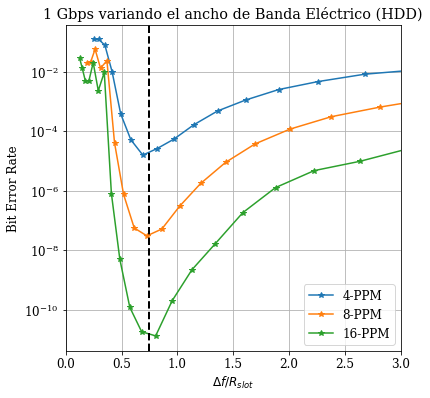

In [32]:
rc('font', **{'family' : 'serif', 'size' : 12})
figure(figsize=(6,6))
title('1 Gbps variando el ancho de Banda Eléctrico (HDD)')

Rb = 1e9

Df4,ber4_teo_H,_, ber4_est_H, ber4_est_S,_,_ = np.loadtxt('BER vs. Df (1 Gbps 4-PPM P_rx=-57dbm BW_opt = 25GHz).txt', unpack=True)
Df8,ber8_teo_H,_,ber8_est_H,ber8_est_S,_,_ = np.loadtxt('BER vs. Df (1 Gbps 8-PPM P_rx=-57dbm BW_opt = 25GHz).txt', unpack=True)
Df16,ber16_teo_H,_,ber16_est_H,ber16_est_S,_,_ = np.loadtxt('BER vs. Df (1 Gbps 16-PPM P_rx=-57dbm BW_opt = 25GHz).txt', unpack=True)

semilogy(Df4/(Rb*4/2), ber4_est_H, 'C0*-', label='4-PPM')

semilogy(Df8/(Rb*8/3), ber8_est_H, 'C1*-', label='8-PPM')

semilogy(Df16/(Rb*16/4), ber16_est_H, 'C2*-', label='16-PPM')

# xlabel(r'$\Delta f/R_{slot}$')
ylabel('Bit Error Rate')
grid(which='both')
legend(loc='lower right')
xlim(0,3)
axvline(0.75,c='k',ls='--',lw=2)
show()

## BER vs. $\hat{P_{rx}}$ para 4,8,16-PPM con Hard y Soft Decision. Tasa de transmisión de 1 Gb/s

### Para generar curvas simuladas

In [ ]:
alpha = 0.75  # factor por el cual se debe multiplicar la tasa de slots para obtener el ancho de banda óptimo del receptor
Rb = 1e9

k = 2
M = 2**k

P_laser = np.arange(-8,12,1) # para 4-PPM
# P_laser = np.arange(-5,13,1) # para 8-PPM
# P_laser = np.arange(-2,16,1) # para 16-PPM

def PPM_link(P_laser):
    p = Parametros(P_laser = P_laser,
                    bit_rate = Rb, 
                    nbits = 10**5, 
                    sps = int(50*k/M + 12),  # debe ser tal que la frecuencia de muestreo sea mayo al doble del ancho de banda del filtro óptico.
                    BW_opt = 25e9, 
                    BW_elec = alpha*Rb*M/k,  # el ancho de banda del detector se fija a 3/4 del Slot_rate
                    G_rx = 40, 
                    NF_rx = 5, 
                    G_tx = 30, 
                    landa = 1550e-9, 
                    Responsivity = 1.0, 
                    orden_elec = 4, 
                    orden_opt = 4,
                    CHANNEL_LOSS = 81,
                    M = M)

    Tx = Transmisor(p)
    Ch = Canal(p, Tx.OUT)
    Rx = Receptor(p, Ch.OUT, Tx.ook_s)

    return power(Rx.IN,'dbm'), Rx.BER_teo_H, Rx.BER_teo_S, Rx.BER_est_H, Rx.BER_est_S, Rx.BER_count_H, Rx.BER_count_S

P_med, BER_teo_H, BER_teo_S, BER_est_H, BER_est_S, BER_count_H, BER_count_S = np.vectorize(PPM_link)(P_laser)

# semilogy(P_med, BER_teo_H, '--', label = 'teo')
# semilogy(P_med, BER_count_H, 'o-', label = 'count')
# semilogy(P_med, BER_est_H, 'v-', label = 'est')
# legend()
# grid()
# xlabel('Sensibilidad [dBm]') 
# ylabel('Bit Error Rate')
# ylim(1e-9,1)
# show()

# np.savetxt(f'BER vs. sensibilidad (1 Gbps {M}-PPM).txt', 
#             np.array([P_med, BER_teo_H, BER_teo_S, BER_est_H, BER_est_S, BER_count_H, BER_count_S]).T,
#             fmt='%e', delimiter='\t', 
#             header='Potencia media\tBER_teo_H\tBER_teo_S\tBER_est_H\tBER_est_S\tBER_count_H\tBER_count_S')


### Para mostrar las curvas simuladas

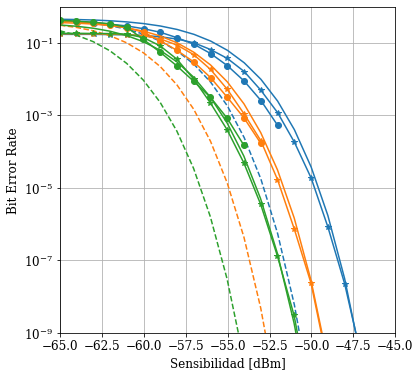

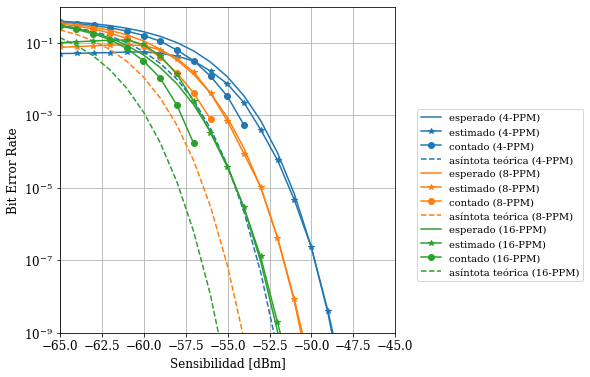

In [63]:
figure(figsize=(6,6))
rc('font', **{'family' : 'serif', 'size' : 12})
# title('Curvas simuladas para 1 Gb/s (DECISIÓN DURA)')

# p,ber_teo,ber_sim,_ = np.loadtxt('D:/ESTUDIO/Telecom/Tesis/3-SISTEMA-OOK/Scrips v2.0/BER vs. Prec (1Gbps).txt', unpack=True)
# semilogy(p,ber_sim, 'rv-', label = 'OOK')

p4, ber4_teo_H, ber4_teo_S, ber4_est_H, ber4_est_S, ber4_count_H, ber4_count_S = np.loadtxt('BER vs. sensibilidad (1 Gbps 4-PPM).txt', unpack=True)
semilogy(p4, ber4_teo_H, 'C0-', label='esperado (4-PPM)')
semilogy(p4, ber4_est_H, 'C0*-', label='estimado (4-PPM)')
semilogy(p4[ber4_count_H!=0], ber4_count_H[ber4_count_H!=0], '-oC0', label='contado (4-PPM)')

BER_H = np.vectorize(Peb_H)(4,1.0,idb(3),idb(40),c/1550e-9, idbm(p4)*4, 25e9, 0.5*2*1e9, 300)
semilogy(p4, BER_H, '--C0', label='asíntota teórica (4-PPM)')

p8, ber8_teo_H, ber8_teo_S, ber8_est_H, ber8_est_S, ber8_count_H, ber8_count_S = np.loadtxt('BER vs. sensibilidad (1 Gbps 8-PPM).txt', unpack=True)
semilogy(p8, ber8_teo_H, 'C1-', label='esperado (8-PPM)')
semilogy(p8, ber8_est_H, 'C1*-', label='estimado (8-PPM)')
semilogy(p8[ber8_count_H!=0], ber8_count_H[ber8_count_H!=0], '-oC1', label='contado (8-PPM)')

BER_H = np.vectorize(Peb_H)(8,1.0,idb(3),idb(40),c/1550e-9, idbm(p8)*8, 25e9, 0.5*8/3*1e9, 300)
semilogy(p8, BER_H, '--C1', label='asíntota teórica (8-PPM)')

p16, ber16_teo_H, ber16_teo_S, ber16_est_H, ber16_est_S, ber16_count_H, ber16_count_S = np.loadtxt('BER vs. sensibilidad (1 Gbps 16-PPM).txt', unpack=True)
semilogy(p16, ber16_teo_H, 'C2-', label='esperado (16-PPM)')
semilogy(p16, ber16_est_H, 'C2*-', label='estimado (16-PPM)')
semilogy(p16[ber16_count_H!=0], ber16_count_H[ber16_count_H!=0], '-oC2', label='contado (16-PPM)')

BER_H = np.vectorize(Peb_H)(16,1.0,idb(3),idb(40),c/1550e-9, idbm(p16)*16, 25e9, 0.5*4*1e9, 300)
semilogy(p16, BER_H, '--C2', label='asíntota teórica (16-PPM)')

xlabel('Sensibilidad [dBm]')
ylabel('Bit Error Rate')
# legend(fontsize = 10, bbox_to_anchor = (1.05, 0.7))
grid(which='both')
ylim(1e-9,1)
xlim(-65,-45)
savefig('Cp3-sensibilidad_H.png', bbox_inches='tight', dpi=300)

figure(figsize=(6,6))
# title('Curvas simuladas para 1 Gb/s (DECISIÓN SUAVE)')

semilogy(p4, ber4_teo_S, '-C0', label='esperado (4-PPM)')
semilogy(p4, ber4_est_S, '-*C0', label='estimado (4-PPM)')
semilogy(p4[ber4_count_S!=0], ber4_count_S[ber4_count_S!=0], '-oC0', label='contado (4-PPM)')

BER_S = np.vectorize(Peb_S)(4,1.0,idb(3),idb(40),c/1550e-9, idbm(p4)*4, 25e9, 0.5*2*1e9, 300)
semilogy(p4, BER_S, '--C0', label='asíntota teórica (4-PPM)')

semilogy(p8, ber8_teo_S, '-C1', label='esperado (8-PPM)')
semilogy(p8, ber8_est_S, '-*C1', label='estimado (8-PPM)')
semilogy(p8[ber8_count_S!=0], ber8_count_S[ber8_count_S!=0], '-oC1', label='contado (8-PPM)')

BER_S = np.vectorize(Peb_S)(8,1.0,idb(3),idb(40),c/1550e-9, idbm(p8)*8, 25e9, 0.5*8/3*1e9, 300)
semilogy(p8, BER_S, '--C1', label='asíntota teórica (8-PPM)')

semilogy(p16, ber16_teo_S, '-C2', label='esperado (16-PPM)')
semilogy(p16, ber16_est_S, '-*C2', label='estimado (16-PPM)')
semilogy(p16[ber16_count_S!=0], ber16_count_S[ber16_count_S!=0], '-oC2', label='contado (16-PPM)')

BER_S = np.vectorize(Peb_S)(16,1.0,idb(3),idb(40),c/1550e-9, idbm(p16)*16, 25e9, 0.5*4*1e9, 300)
semilogy(p16, BER_S, '--C2', label='asíntota teórica (16-PPM)')

xlabel('Sensibilidad [dBm]')
ylabel('Bit Error Rate')
grid(which='both')
legend(fontsize = 10, bbox_to_anchor = (1.05, 0.7))
ylim(1e-9,1)
xlim(-65,-45)
savefig('Cp3-sensibilidad_S.png', bbox_inches='tight', dpi=300)
show()

## BER vs. $\Delta \nu_{opt}$ para {4,8,16}-PPM con Hard y Soft Decision. Tasa de transmisión de 1 Gb/s y Potencia recibida -57 dBm

### Para generar las curvas simuladas

In [ ]:
M = 16
k = int(np.log2(M))

Prx = -57 + 10*np.log10(M) # potencia pico fijada de los pulsos recibidos en dBm

BER_teo_H, BER_count_HDD, BER_count_SDD, BER_est_H = [],[],[],[]

BW_opt = np.logspace(np.log10(0.5*0.75e9*M/k), np.log10(25e9), 11)

for bw_opt in BW_opt:
    params = Parametros(Ptx = Prx,
                    bit_rate = 1e9, 
                    nbits = 10**6, 
                    sps = 64, 
                    BW_opt = bw_opt, 
                    BW_elec = 0.75e9*M/k,  # el ancho de banda del detector se fija a 3/4 del Slot_rate
                    G_rx = 40, 
                    NF_rx = 5, 
                    G_tx = 0, 
                    NF_tx = 0, 
                    landa = 1550e-9, 
                    Responsivity = 1.0, 
                    orden_elec = 4, 
                    orden_opt = 4,
                    CHANNEL_LOSS = 81,
                    M = M)
    rec = Receptor(params)
    BER_teo_H.append(rec.BER_teo_H)
    BER_count_HDD.append(rec.BER_HDD)
    BER_count_SDD.append(rec.BER_SDD)
    BER_est_H.append(rec.BER_est_H)

# np.savetxt(f'BER vs. BW_opt (1 Gbps {M}-PPM Prx=-57dbm)', 
#             np.array([BW_opt, BER_teo_H, BER_count_HDD, BER_count_SDD, BER_est_H]).T,
#             fmt='%e', delimiter='\t', 
#             header='BW_opt\tBER_teo_H\tBER_count_HDD\tBER_count_SDD\tBER_est_H')

### Para mostrar las curvas simuladas

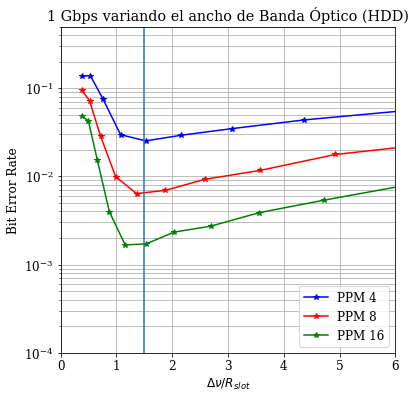

In [7]:
bw_op4,ber4_teo,ber4_H,ber4_S,ber4_est = np.loadtxt('BER vs. BW_opt (1 Gbps 4-PPM Prx=-57dbm)', unpack=True)
bw_op8,ber8_teo,ber8_H,ber8_S,ber8_est = np.loadtxt('BER vs. BW_opt (1 Gbps 8-PPM Prx=-57dbm)', unpack=True)
bw_op16,ber16_teo,ber16_H,ber16_S,ber16_est = np.loadtxt('BER vs. BW_opt (1 Gbps 16-PPM Prx=-57dbm)', unpack=True)

Rb = 1e9

rc('font', **{'family' : 'serif', 'size' : 12})
figure(figsize=(6,6))
title('1 Gbps variando el ancho de Banda Óptico (HDD)')
# semilogy(bw_op4*1e-9, ber4_teo, 'b-', label='PPM 4 teo')
# semilogy(bw_op4*1e-9, ber4_S, 'bv-', label='PPM 4')
semilogy(bw_op4/(Rb*2), ber4_est, 'b*-', label='PPM 4')
# semilogy(bw_op8*1e-9, ber8_teo, 'r-', label='PPM 8 teo')
# semilogy(bw_op8*1e-9, ber8_S, 'rv-', label='PPM 8')
semilogy(bw_op8/(Rb*8/3), ber8_est, 'r*-', label='PPM 8')
# semilogy(bw_op16*1e-9, ber16_teo, 'g-', label='PPM 16 teo')
# semilogy(bw_op16*1e-9, ber16_S, 'gv-', label='PPM 16')
semilogy(bw_op16/(Rb*4), ber16_est, 'g*-', label='PPM 16')
xlabel(r'$\Delta \nu / R_{slot}$')
ylabel('Bit Error Rate')
grid(which='both')
legend(loc='lower right')
ylim(1e-4,0.5)
xlim(0,6)
axvline(3/2)
show()


## BER vs. Bit_rate para {4,8,16}-PPM con Hard y Soft Decision. Potencia recibida -57 dBm

In [ ]:
M = 32
k = np.log2(M)

# Para lograr la misma potencia media recibida (-57 dbm)
# P_laser = 0 # dbm, para M=4
# P_laser = 3 # dbm, para M=8
P_laser = 6 # dbm, para M=16
# P_laser = 9 # dbm, para M=32

Rb = np.logspace(np.log10(0.5e9), np.log10(10e9), 20)

def PPM_link(Rb):
    p = Parametros(P_laser = P_laser,
                    bit_rate = Rb, 
                    nbits = 10**4, 
                    sps = 128, #int(50*k/M + 12),  # debe ser tal que la frecuencia de muestreo sea mayo al doble del ancho de banda del filtro óptico.
                    BW_opt = 25e9, 
                    BW_elec = 0.75*Rb*M/k,  # el ancho de banda del detector se fija a 3/4 del Slot_rate
                    G_rx = 40, 
                    NF_rx = 5, 
                    G_tx = 30, 
                    landa = 1550e-9, 
                    Responsivity = 1.0, 
                    orden_elec = 4, 
                    orden_opt = 4,
                    CHANNEL_LOSS = 81,
                    M = M)

    Tx = Transmisor(p)
    Ch = Canal(p, Tx.OUT)
    Rx = Receptor(p, Ch.OUT, Tx.ook_s)

    return Rx.BER_teo_H, Rx.BER_teo_S, Rx.BER_est_H, Rx.BER_est_S, Rx.BER_count_H, Rx.BER_count_S

BER_teo_H, BER_teo_S, BER_est_H, BER_est_S, BER_count_H, BER_count_S = np.vectorize(PPM_link)(Rb)

semilogy(Rb*1e-9, BER_est_H, 'b-', label=f'{M}-PPM')
grid()
xlabel('Rb [Gb/s]')
ylabel('Bit Error Rate')
legend()


# np.savetxt('BER vs. Rb (%d-PPM Prx=-57dbm Dv = 25GHz Df=0.75Slot_rate).txt' % M, 
#             np.array([Rb, BER_teo_H, BER_teo_S, BER_est_H, BER_est_S, BER_count_H, BER_count_S]).T,
#             fmt='%e', delimiter='\t', 
#             header='Bit_rate\tBER_teo_H\tBER_teo_S\tBER_est_H\tBER_est_S\tBER_count_H\tBER_count_S')


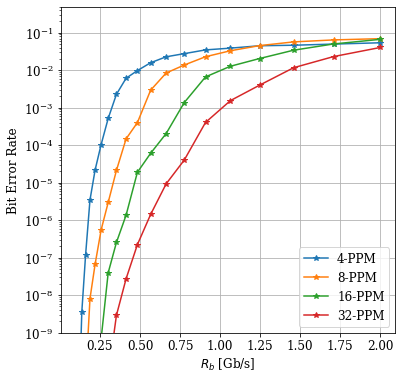

In [7]:
rc('font', **{'family' : 'serif', 'size' : 12})
# title('Variando la tasa de Transmisión de bits')
figure(figsize=(6,6))

Rb = np.logspace(np.log10(0.1e9), np.log10(2e9), 20)
Rb4,_,_,ber4_est_H,ber4_est_S,_,_ = np.loadtxt('BER vs. Rb (4-PPM Prx=-57dbm Dv = 25GHz Df=0.75Slot_rate).txt', unpack=True)
Rb8,_,_,ber8_est_H,ber8_est_S,_,_ = np.loadtxt('BER vs. Rb (8-PPM Prx=-57dbm Dv = 25GHz Df=0.75Slot_rate).txt', unpack=True)
Rb16,_,_,ber16_est_H,ber16_est_S,_,_ = np.loadtxt('BER vs. Rb (16-PPM Prx=-57dbm Dv = 25GHz Df=0.75Slot_rate).txt', unpack=True)
Rb32,_,_,ber32_est_H,ber32_est_S,_,_ = np.loadtxt('BER vs. Rb (32-PPM Prx=-57dbm Dv = 25GHz Df=0.75Slot_rate).txt', unpack=True)


semilogy(Rb*1e-9, ber4_est_S, 'C0*-', label='4-PPM')
semilogy(Rb*1e-9, ber8_est_S, 'C1*-', label='8-PPM')
semilogy(Rb*1e-9, ber16_est_S, 'C2*-', label='16-PPM')
semilogy(Rb*1e-9, ber32_est_S, 'C3*-', label='32-PPM')
xlabel(r'$R_b$ [Gb/s]')
ylabel('Bit Error Rate')
grid()
legend(loc='lower right')
ylim(1e-9,0.5)
# savefig('BER vs. Rb (Prx=-57dbm Dv = 25GHz Df=0.75Slot_rate).png', dpi=300)
show()

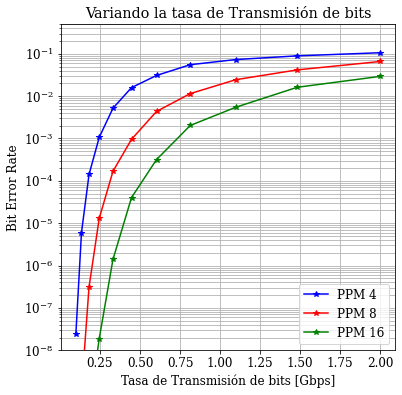

In [ ]:
bit_rate,ber4_teo,ber4_H,ber4_S,ber4_est = np.loadtxt('BER vs. Bit_rate (1 Gbps 4-PPM Prx=-57dbm BW_opt = 15GHz BW=0.75Slot_rate)', unpack=True)
_,ber8_teo,ber8_H,ber8_S,ber8_est = np.loadtxt('BER vs. Bit_rate (1 Gbps 8-PPM Prx=-57dbm BW_opt = 15GHz BW=0.75Slot_rate)', unpack=True)
_,ber16_teo,ber16_H,ber16_S,ber16_est = np.loadtxt('BER vs. Bit_rate (1 Gbps 16-PPM Prx=-57dbm BW_opt = 15GHz BW=0.75Slot_rate)', unpack=True)

rc('font', **{'family' : 'serif', 'size' : 12})
figure(figsize=(6,6))
title('Variando la tasa de Transmisión de bits')
# semilogy(bit_rate*1e-9, ber4_teo, 'b-', label='PPM 4 teo')
# semilogy(bit_rate*1e-9, ber4_S, 'bv-', label='PPM 4')
semilogy(bit_rate*1e-9, ber4_est, 'b*-', label='PPM 4')
# semilogy(bit_rate*1e-9, ber8_teo, 'r-', label='PPM 8 teo')
# semilogy(bit_rate*1e-9, ber8_S, 'rv-', label='PPM 8')
semilogy(bit_rate*1e-9, ber8_est, 'r*-', label='PPM 8')
# semilogy(bit_rate*1e-9, ber16_teo, 'g-', label='PPM 16 teo')
# semilogy(bit_rate*1e-9, ber16_S, 'gv-', label='PPM 16')
semilogy(bit_rate*1e-9, ber16_est, 'g*-', label='PPM 16')
xlabel(r'Tasa de Transmisión de bits [Gbps]')
ylabel('Bit Error Rate')
grid(which='both')
legend(loc='lower right')
ylim(1e-8,0.5)
show()